In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

Data Generation

Input shape: (1000, 2)
Output shape: (1000, 2)


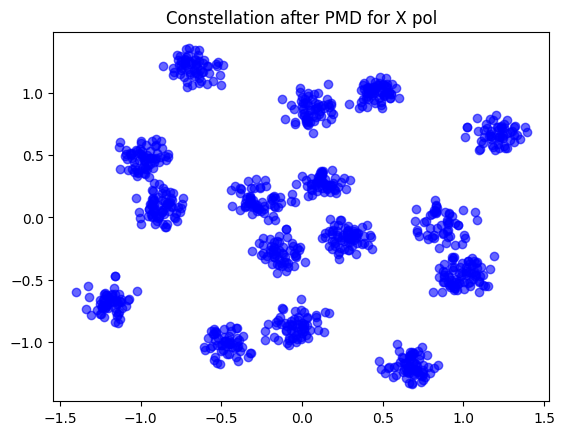

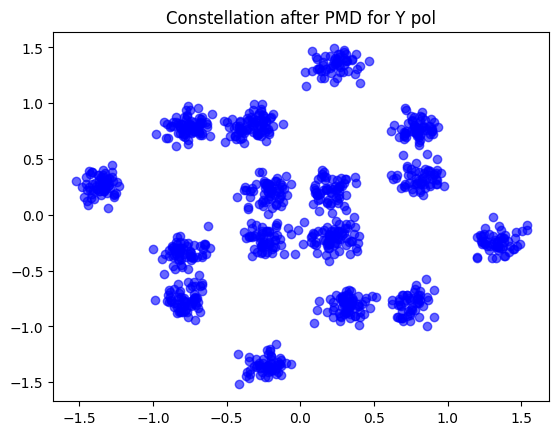

In [2]:
def apply_pmd(E_in, DGD_ps_per_sqrt_km, L_m, N_sections, Rs, SpS):
    N_samples = E_in.shape[0]
    SD_tau = np.sqrt(3 * np.pi / 8) * DGD_ps_per_sqrt_km

    tau = (SD_tau * np.sqrt(L_m * 1e-3) / np.sqrt(N_sections)) * 1e-12
    #tau=0
    w = 2 * np.pi * np.fft.fftshift(np.linspace(-0.5, 0.5, N_samples)) * SpS * Rs

    E_V = np.fft.fft(E_in[:, 0])
    E_H = np.fft.fft(E_in[:, 1])

    for _ in range(N_sections):
        # Random complex coupling matrices (unitary)
        X = np.random.randn(2, 2) + 1j * np.random.randn(2, 2)
        U, _, Vh = np.linalg.svd(X)
        V = Vh.conj().T
        #print("U is",U)
        # Rotate fields by U†
        E1 = U[0, 0].conj() * E_V + U[0, 1].conj() * E_H
        E2 = U[1, 0].conj() * E_V + U[1, 1].conj() * E_H

        #E1=U[0, 0].conj() * E_V
        #E2 = U[1, 1].conj() * E_H
        # Apply differential delay
        E1 *= np.exp(1j * w * tau / 2)
        E2 *= np.exp(-1j * w * tau / 2)

        # Rotate by V
        E_V = V[0, 0] * E1 + V[0, 1] * E2
        E_H = V[1, 0] * E1 + V[1, 1] * E2
        #E_V = V[0, 0] * E1
        #E_H = V[1, 1] * E2

    E_out_x = np.fft.ifft(E_V)
    E_out_y = np.fft.ifft(E_H)

    return np.column_stack((E_out_x, E_out_y))


N_symbols = 1000
levels = np.array([-1, 1]) / np.sqrt(2)
qam_symbols_x = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))
qam_symbols_y = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))

E_in = np.column_stack((qam_symbols_x, qam_symbols_y))  # shape (100, 2)

# check parameters with deepa ma'am
E_out = apply_pmd( 
E_in=E_in, 
DGD_ps_per_sqrt_km=0.8, # typical mean DGD for 3 symbols DGD
L_m=10000, # fiber length
N_sections=20, # number of fiber sections 
Rs=32e9, # 32 gbaud    
SpS=2 # samples per symbol 
)

print("Input shape:", E_in.shape)
print("Output shape:", E_out.shape)

plt.title("Constellation after PMD for X pol")
plt.scatter(E_out[:,0].real, E_out[:,0].imag, color='blue', label='Input X-pol', alpha=0.6)
plt.show()
plt.title("Constellation after PMD for Y pol")
plt.scatter(E_out[:,1].real, E_out[:,1].imag, color='blue', label='Input X-pol', alpha=0.6)
plt.show()


Checking if CMA works for this and if it converges for a baseline

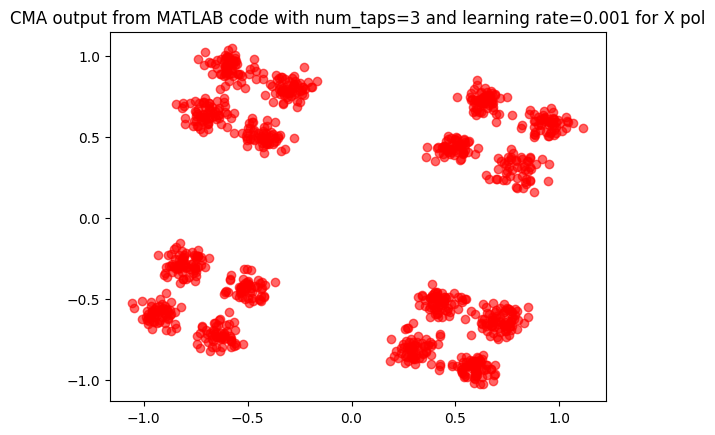

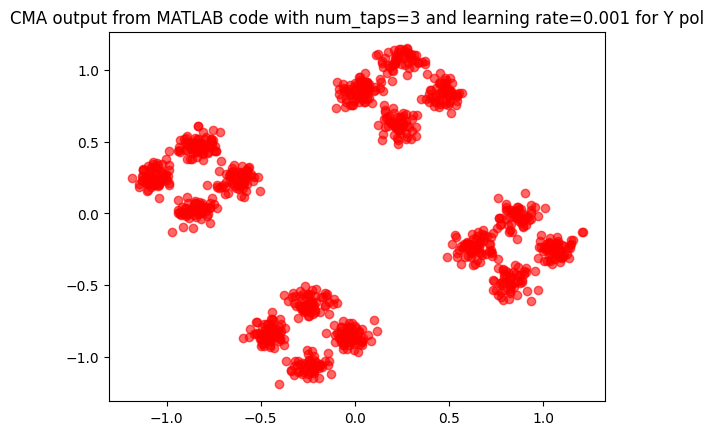

In [3]:
#Using matlab code already written for CMA we will compare this with python also
import matlab.engine
eng = matlab.engine.start_matlab()


#Change this path to where you have saved matlab
eng.addpath(r"C:\optical\Coherent-Optical-Communication\Coherent-Optical-Communication\functions\DSP", nargout=0)

learning_rate=10e-4
num_taps=3
ml_x_pol=matlab.double(E_out[:,0].tolist(),is_complex=True)
ml_x_pol=eng.transpose(ml_x_pol)
ml_y_pol=matlab.double(E_out[:,1].tolist(),is_complex=True)
ml_y_pol=eng.transpose(ml_y_pol)
result_x,result_y=eng.f_DSP_pol_demux_CMA(ml_x_pol,ml_y_pol,num_taps,learning_rate,nargout=2)

#Squeeze output as it is in wierd shape
result_x=np.squeeze(np.array(result_x))
result_y=np.squeeze(np.array(result_y))
#print(result_x)
plt.title(f"CMA output from MATLAB code with num_taps={num_taps} and learning rate={learning_rate} for X pol")
plt.scatter(result_x.real, result_x.imag, color='red', label='Output X-pol', alpha=0.6)
plt.show()


plt.title(f"CMA output from MATLAB code with num_taps={num_taps} and learning rate={learning_rate} for Y pol")
plt.scatter(result_y.real, result_y.imag, color='red', label='Output X-pol', alpha=0.6)
plt.show()

In [4]:
#Using our CMA for better debugging 
#Checking if medha code gives the same results
def cma_pol_demux(E_in, N_taps=11, mu_CMA=0.01, radii=[1]):
    """
    CMA-based equalizer for QAM with multiple radii (multi-modulus CMA)
    
    E_in : ndarray, shape (N_symbols, 2)
        Input dual-pol signal [X, Y] (complex)
    N_taps : int
        Number of taps per filter
    mu_CMA : float
        CMA step size (learning rate)
    radii : list
        Possible radii of QAM constellation points

    Returns
    -------
    E_out : ndarray, shape (N_symbols, 2)
        Equalized dual-pol output
    taps : dict
        Dictionary with final tap coefficients: pxx, pxy, pyx, pyy
    """
    
    xpol = E_in[:, 0] / np.sqrt(np.mean(np.abs(E_in[:, 0])**2))
    ypol = E_in[:, 1] / np.sqrt(np.mean(np.abs(E_in[:, 1])**2))

    N = len(xpol)

    # Initialize taps
    pxx = np.zeros(N_taps, dtype=complex); pxx[N_taps//2+1] = 1
    pxy = np.zeros(N_taps, dtype=complex)
    pyx = np.zeros(N_taps, dtype=complex)
    pyy = np.zeros(N_taps, dtype=complex); pyy[N_taps//2+1] = 1

    xpol = np.concatenate([np.zeros(N_taps-1, dtype=complex), xpol])
    ypol = np.concatenate([np.zeros(N_taps-1, dtype=complex), ypol])

    for ii in range(N_taps-1, len(xpol)):
        # convolution:
        x_vec = xpol[ii-(N_taps-1):ii+1][::-1]
        y_vec = ypol[ii-(N_taps-1):ii+1][::-1]
        
        x_cap = np.dot(pxx, x_vec) + np.dot(pxy, y_vec)
        y_cap = np.dot(pyx, x_vec) + np.dot(pyy, y_vec)

        # find closest radius before finding error
        R_x = min(radii, key=lambda r: abs(np.abs(x_cap) - r))
        R_y = min(radii, key=lambda r: abs(np.abs(y_cap) - r))

        # CMA error for multi-modulus
        e_x = R_x**2 - np.abs(x_cap)**2
        e_y = R_y**2 - np.abs(y_cap)**2
        #print(e_x,e_y)
        #print(x_vec)
        # update taps
        pxx += 2 * mu_CMA * e_x * x_cap * np.conj(x_vec)
        pxy += 2 * mu_CMA * e_x * x_cap * np.conj(y_vec)
        pyx += 2 * mu_CMA * e_y * y_cap * np.conj(x_vec)
        pyy += 2 * mu_CMA * e_y * y_cap * np.conj(y_vec)

    # updating filters
    #print(R_x,R_y)
    x_out = np.convolve(xpol, pxx, mode='same') + np.convolve(ypol, pxy, mode='same')
    y_out = np.convolve(xpol, pyx, mode='same') + np.convolve(ypol, pyy, mode='same')

    # remove zero-padding
    x_out = x_out[N_taps-1:]
    y_out = y_out[N_taps-1:]

    E_out = np.column_stack((x_out, y_out))
    taps = {'pxx': pxx, 'pxy': pxy, 'pyx': pyx, 'pyy': pyy}

    return E_out, taps


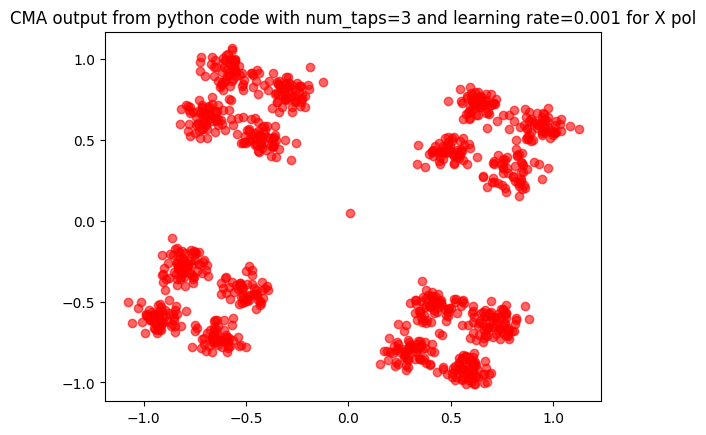

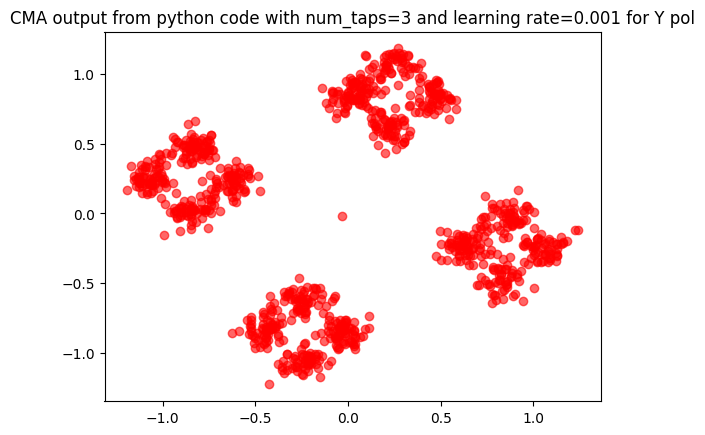

taps are {'pxx': array([7.11549970e-04-7.17863521e-05j, 3.61630669e-02-2.43276044e-03j,
       8.60999586e-01+6.70058657e-04j]), 'pxy': array([-0.00467952-0.01342008j,  0.00041773+0.01616774j,
       -0.18759185+0.24707795j]), 'pyx': array([ 0.01328794-0.00053623j, -0.01572698-0.0194046j ,
        0.18857455+0.25484979j]), 'pyy': array([ 0.00598916-0.0037183j , -0.03344842+0.00923252j,
        0.84241132+0.00281404j])}


In [5]:
result_py_func,taps=cma_pol_demux(E_out,num_taps,learning_rate)
result_py_func_x,result_py_func_y=result_py_func[:,0],result_py_func[:,1]
plt.title(f"CMA output from python code with num_taps={num_taps} and learning rate={learning_rate} for X pol")
plt.scatter(result_py_func_x.real, result_py_func_x.imag, color='red', label='Output X-pol', alpha=0.6)
plt.show()


plt.title(f"CMA output from python code with num_taps={num_taps} and learning rate={learning_rate} for Y pol")
plt.scatter(result_py_func_y.real, result_py_func_y.imag, color='red', label='Output X-pol', alpha=0.6)
plt.show()

print("taps are",taps)

DQN network to solve the same problem

In [6]:
#Setting
E_in_matrix=E_out

#Hyperparameters for DQN
tau=0.01
num_hidden_dim=64
replay_buffer_cap=10000
sampling_batch_size=64



In [7]:
def apply_filters(E_in,cur_ind,num_taps, pxx, pxy, pyx, pyy):
    
    
    x_in = E_in[:, 0] / np.sqrt(np.mean(np.abs(E_in[:, 0])**2))
    y_in = E_in[:, 1] / np.sqrt(np.mean(np.abs(E_in[:, 1])**2))

    x=x_in[cur_ind-num_taps+1:cur_ind+1][::-1]
    y=y_in[cur_ind-num_taps+1:cur_ind+1][::-1]

    #print(x,y,cur_ind,cur_ind-num_taps)
    
    x_out=np.dot(pxx,x)+np.dot(pxy,y)
    y_out=np.dot(pyx,x)+np.dot(pyy,y)
    return x_out,y_out


# def cma_error_dualpol(E_out, radii=[np.sqrt(1)]):

#     xpol = E_out[:, 0]/ np.sqrt(np.mean(np.abs(E_out[:, 0])**2))
#     ypol = E_out[:, 1]/ np.sqrt(np.mean(np.abs(E_out[:, 1])**2))



#     e_total = 0.0

#     for x_cap, y_cap in zip(xpol, ypol):
#         R_x = min(radii, key=lambda r: abs(np.abs(x_cap) - r))
#         R_y = min(radii, key=lambda r: abs(np.abs(y_cap) - r))

#         e_x = (np.abs(x_cap)**2 - R_x**2)**2
#         e_y = (np.abs(y_cap)**2 - R_y**2)**2
#         e_total += e_x + e_y

#     return e_total / len(xpol)


def cma_error_dualpol(x_out,y_out,Radius=1):
    e_x=((np.abs(x_out)**2-Radius**2))**2
    e_y=((np.abs(y_out)**2-Radius**2))**2
    return e_x+e_y

def get_cma_action(E_in_matrix,x_out,y_out,cur_ind,Radius=1):
    
    x_in = E_in[:, 0] / np.sqrt(np.mean(np.abs(E_in[:, 0])**2))
    y_in = E_in[:, 1] / np.sqrt(np.mean(np.abs(E_in[:, 1])**2))


    x=x_in[cur_ind-num_taps+1:cur_ind+1][::-1]
    y=y_in[cur_ind-num_taps+1:cur_ind+1][::-1]
    e_x=Radius**2-np.abs(x_out)**2
    e_y=Radius**2-np.abs(y_out)**2
    

    cma_update_arr_pxx=e_x*x_out*np.conj(x)
    cma_update_arr_pxy=e_x*x_out*np.conj(y)
    cma_update_arr_pyx=e_y*y_out*np.conj(x)
    cma_update_arr_pyy=e_y*y_out*np.conj(y)
    
    def find_max_across_filters(cma_update_arr_pxx, cma_update_arr_pxy, 
                           cma_update_arr_pyx, cma_update_arr_pyy):
        """
        Find maximum absolute value across all filter updates (real and imaginary parts).
        
        Returns:
            filter_num: 0=pxx, 1=pxy, 2=pyx, 3=pyy
            tap_num: index of the tap
            real_or_imag: 0=real, 1=imaginary
            sign: sign of the maximum value (-1 or +1)
        """
        # Stack all arrays
        all_arrays = [cma_update_arr_pxx, cma_update_arr_pxy, 
                    cma_update_arr_pyx, cma_update_arr_pyy]
        
        # Create a combined array with real and imaginary parts
        # Shape: (4 filters, num_taps, 2 [real/imag])
        num_taps = all_arrays[0].shape[0]

        #print("num_taps is",num_taps)
        combined = np.zeros((4, num_taps, 2))
        
        for i, arr in enumerate(all_arrays):
            combined[i, :, 0] = np.real(arr)
            combined[i, :, 1] = np.imag(arr)
        
        # Find the index of maximum absolute value
        max_abs_idx = np.abs(combined).argmax()
        
        # Convert flat index to 3D indices
        filter_num, tap_num, real_or_imag = np.unravel_index(max_abs_idx, combined.shape)
        
        # Get the sign of that value
        max_value = combined[filter_num, tap_num, real_or_imag]
        sign = int(np.sign(max_value))
        
        return int(filter_num), int(tap_num), int(real_or_imag), sign

    return find_max_across_filters(cma_update_arr_pxx,cma_update_arr_pxy,cma_update_arr_pyx,cma_update_arr_pyy)
    

def compute_reward(x_out,y_out):
    
    #x_out,y_out=apply_filters(E_in_matrix,cur_ind,num_taps,*filters)
    return -cma_error_dualpol(x_out,y_out)



In [8]:
x_out,y_out=apply_filters(E_in_matrix,500,num_taps,taps['pxx'],taps['pxy'],taps['pyx'],taps['pyy']) 
print(x_out,y_out)
print("Ideal reward is",compute_reward(x_out,y_out))

(0.6115927802177429-0.9422778533659011j) (0.5553074662355173-0.21391889318798762j)
Ideal reward is -0.4857601043973364


In [9]:
class QNetwork(nn.Module):
    def __init__(self,state_dim,num_actions,hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.temp1=nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_actions)  # 4 channel * 3 coeffs per channel * real and imag parts for each coeff * inc/dec each
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x=F.leaky_relu(self.temp1(x))
        return self.fc3(x)

In [10]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = zip(*batch)
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states)
        )

    def __len__(self):
        return len(self.buffer)

In [11]:
class DQNAgent:
    def __init__(self, num_taps_per_filter, delta=0.01, gamma=0.99, lr=0.005):
        
        self.num_taps_per_filter = num_taps_per_filter
        self.num_filters=4
        #We set our state dimension as twice the total number_coefficients as we have real and imaginary parts
        self.num_coeffs=num_taps_per_filter*self.num_filters
        self.state_dim = 2*self.num_coeffs
        #Number of actiosn are for each real and imaginary part of state we can inc dec stay same
        self.num_actions=2*self.num_coeffs*3
        self.action_map=self.create_action_to_coeff_and_direction_map()
        self.coeff_map=self.create_coeff_dir_to_action_map()
        
        self.delta = delta
        self.gamma = gamma


        self.q_net = QNetwork(self.state_dim,self.num_actions,hidden_dim=256)
        self.target_net = QNetwork(self.state_dim,self.num_actions,hidden_dim=256)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer()
        self.loss_fn = nn.MSELoss()

    def create_action_to_coeff_and_direction_map(self):
        """This function is used to create a dict which maps action_num:[filter_ind,tap_ind,real_or_imag,direction(which can be -1,0,1)].
        The actions are numbered from 0 to num_actions-1 and it will be in increasing order where direction changes first then real_imag so on."""
        action_coeff_map = {}
    
        # Define the possible directions
        directions = [-1, 0, 1]
        
        # Define real vs imaginary components
        real_or_imag = [0, 1]  # 0 for real, 1 for imaginary
        
        action_num = 0
        
        # Iterate in order: filter_ind -> tap_ind -> real_or_imag -> direction
        for filter_num in range(self.num_filters):
            for tap_num in range(self.num_taps_per_filter):
                for ri in real_or_imag:
                    for direction in directions:
                        action_coeff_map[action_num]=[filter_num,tap_num,ri,direction]
                        action_num+=1
        
        return action_coeff_map

    def create_coeff_dir_to_action_map(self):
        """This function maps [filter_ind,tap_ind,ri,direction] to the corresponding action"""
        coeff_dict={}
        for action in self.action_map:
            coeff_dict[tuple(self.action_map[action])]=action
        return coeff_dict

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.num_actions - 1)
        with torch.no_grad():
            q_vals = self.q_net(torch.FloatTensor(state))
            return torch.argmax(q_vals).item()

    def update(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return None
        states, actions, rewards, next_states = self.replay_buffer.sample(batch_size)
        q_vals = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_vals = self.target_net(next_states).max(1)[0]
            targets = rewards + self.gamma * next_q_vals
        loss = self.loss_fn(q_vals, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def soft_update(self, tau=0.01):
        for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [13]:
num_taps = 3
num_coeffs = num_taps * 4   # 4 channels * 3 taps = 12 complex coeffs
num_episodes = 400
steps_per_episode = len(E_in_matrix[:,0])
delta = 1e-3

agent = DQNAgent(num_taps_per_filter=num_taps, delta=delta,lr=5e-4)
epsilon, epsilon_min, epsilon_decay = 1.0, 0.05, 0.995

for episode in range(num_episodes):
    # initialize filter weights
    # pxx =  [(0.19278588742874891+0.13659670282519232j), (0.5184388346473833-0.5003078897671651j), (0.718335683460289+0.8954418804765679j)]
    # pxy =  [(0.6218276414993511-0.39189081610647436j), (0.5600745006595894+0.6758716110364135j), (0.09195882344299255+0.8283914307009889j)]
    # pyx =  [(0.4490470782749889+0.8029232400353175j), (0.4795070851702994-0.6948455559193323j), (0.32420210797652127+0.04877111021697689j)]
    # pyy =  [(0.22222171226176357-0.6656413597730969j), (0.15826636212898026+0.8327775913293115j), (0.7921226200898618+0.24991332750261175j)]

    pxx=taps['pxx']
    pxy=taps['pxy']
    pyx=taps['pyx']
    pyy=taps['pyy']
    # ideal coefficients:

    # state = real and imag parts of all coefficients
    state = np.concatenate([
        np.real(np.concatenate([pxx, pxy, pyx, pyy])),
        np.imag(np.concatenate([pxx, pxy, pyx, pyy]))
    ])
    #print(state)

    filters_state = [pxx, pxy, pyx, pyy]
    x_out,y_out=apply_filters(E_in_matrix,num_taps-1,num_taps,*filters_state)
    #print("yout is",y_out)
    #print(agent.coeff_map[get_cma_action(E_in_matrix,x_out,y_out,num_taps-1)])
    for cur_sample in range(num_taps,steps_per_episode):

        #action = agent.select_action(state, epsilon) #Here action represents the output action index selected

        #Use cma directed action to get where to go as it always gives some value we will never do the do nothing action
        if random.random() < epsilon:
            action=random.randint(0, agent.num_actions - 1)
        else:
            coeffs=get_cma_action(E_in_matrix,x_out,y_out,num_taps-1,Radius=1)  
            action=agent.coeff_map[coeffs]
        
        filter_num,tap_num,real_imag,direction=agent.action_map[action]
        

        if real_imag==0:
            "Change the real part"
            filters_state[filter_num][tap_num]+= direction*delta
        elif real_imag==1:
            filters_state[filter_num][tap_num]+=1j*direction*delta
        # update chosen coefficient
        x_out,y_out = apply_filters(E_in_matrix,cur_sample,num_taps,*filters_state)
        reward = compute_reward(x_out,y_out)

        next_state = np.concatenate([
            np.real(np.concatenate(filters_state)),
            np.imag(np.concatenate(filters_state))
        ])

        agent.replay_buffer.push(state, action, reward, next_state)
        state = next_state
        loss = agent.update()
        agent.soft_update(tau=0.5)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 5 == 0:
        print(f"Episode {episode+1}, epsilon={epsilon:.3f}, last_loss={loss:.6f}, reward={reward:.6f}")

print("\nTraining complete")
print("Final filters:")
print("pxx = ", pxx)
print("pxy = ", pxy)
print("pyx = ", pyx)
print("pyy = ", pyy)

Episode 5, epsilon=0.975, last_loss=1624.252563, reward=-0.972196
Episode 10, epsilon=0.951, last_loss=2099.771484, reward=-0.866834
Episode 15, epsilon=0.928, last_loss=1591.128296, reward=-0.837496
Episode 20, epsilon=0.905, last_loss=3134.933105, reward=-0.794057
Episode 25, epsilon=0.882, last_loss=2501.871582, reward=-0.861342
Episode 30, epsilon=0.860, last_loss=4335.864746, reward=-0.829192
Episode 35, epsilon=0.839, last_loss=2650.481201, reward=-0.894194
Episode 40, epsilon=0.818, last_loss=1349.450562, reward=-0.885101
Episode 45, epsilon=0.798, last_loss=2333.951904, reward=-0.915767


KeyboardInterrupt: 

In [16]:
#print(agent.update())
print(agent.q_net.fc1.weight)


Parameter containing:
tensor([[ 0.0994,  0.0041, -0.0412,  ...,  0.0702, -0.1772,  0.0700],
        [ 0.2230, -0.1378,  0.2273,  ...,  0.2785,  0.1546, -0.2175],
        [-0.2299, -0.0885, -0.1433,  ...,  0.0721,  0.0483,  0.1766],
        ...,
        [ 0.0278,  0.0818,  0.1477,  ...,  0.0085, -0.0678,  0.1162],
        [-0.2155,  0.2752,  0.0259,  ..., -0.1232, -0.1722,  0.2722],
        [-0.0050,  0.1710, -0.1217,  ...,  0.0584, -0.2146,  0.2069]],
       requires_grad=True)


Testing the model by trying it on the same data and plotting the constellation 

In [20]:
num_taps = 3
num_coeffs = num_taps * 4   # 4 channels * 3 taps = 12 complex coeffs
num_episodes = 400
steps_per_episode = len(E_in_matrix[:,0])
delta = 0.02

epsilon_test, epsilon_min, epsilon_decay = 0.01, 0.05, 0.995

# initialize filter weights

# ideal coefficients:

pxx=taps['pxx']
pxy=taps['pxy']
pyx=taps['pyx']
pyy=taps['pyy']

print("original filters:")
print("pxx = ", pxx)
print("pxy = ", pxy)
print("pyx = ", pyx)
print("pyy = ", pyy)
# state = real and imag parts of all coefficients
state = np.concatenate([
    np.real(np.concatenate([pxx, pxy, pyx, pyy])),
    np.imag(np.concatenate([pxx, pxy, pyx, pyy]))
])
#print(state)

filters_state = [pxx, pxy, pyx, pyy]
x_out,y_out=apply_filters(E_in_matrix,num_taps-1,num_taps,*filters_state)
#print("yout is",y_out)
#print(agent.coeff_map[get_cma_action(E_in_matrix,x_out,y_out,num_taps-1)])
for cur_sample in range(num_taps,steps_per_episode):

    action = agent.select_action(state, epsilon_test) #Here action represents the output action index selected

    #Use cma directed action to get where to go as it always gives some value we will never do the do nothing action
    
    filter_num,tap_num,real_imag,direction=agent.action_map[action]
    

    if real_imag==0:
        "Change the real part"
        filters_state[filter_num][tap_num]+= direction*delta
    elif real_imag==1:
        filters_state[filter_num][tap_num]+=1j*direction*delta
    # update chosen coefficient
    x_out,y_out = apply_filters(E_in_matrix,cur_sample,num_taps,*filters_state)
    reward = compute_reward(x_out,y_out)

    next_state = np.concatenate([
        np.real(np.concatenate(filters_state)),
        np.imag(np.concatenate(filters_state))
    ])


epsilon = max(epsilon_min, epsilon * epsilon_decay)

if (episode + 1) % 5 == 0:
    print(f"Episode {episode+1}, epsilon={epsilon:.3f}, last_loss={loss:.6f}, reward={reward:.6f}")

print("\nTraining complete")
print("Final filters:")
print("pxx = ", filters_state[0])
print("pxy = ", filters_state[1])
print("pyx = ", filters_state[2])
print("pyy = ", filters_state[3])

original filters:
pxx =  [ 0.15171155 -0.64507179j -0.31583693+20.77556724j
  0.95599959 -0.13932994j]
pxy =  [ 0.38632048-1.13842008j  0.23641773-0.05683226j -0.30959185+0.56107795j]
pyx =  [ 0.41728794+0.20546377j -0.27472698+0.2335954j  -0.25342545-0.14115021j]
pyy =  [-0.41301084+0.1472817j   0.36155158+0.12223252j  1.15041132-0.79918596j]

Training complete
Final filters:
pxx =  [ 0.15171155 -0.66507179j -0.31583693+40.55556724j
  0.95599959 -0.13932994j]
pxy =  [ 0.38632048-1.13842008j  0.21641773-0.05683226j -0.32959185+0.56107795j]
pyx =  [ 0.41728794+0.20546377j -0.27472698+0.2535954j  -0.25342545-0.14115021j]
pyy =  [-0.41301084+0.1472817j   0.38155158+0.12223252j  1.15041132-0.83918596j]


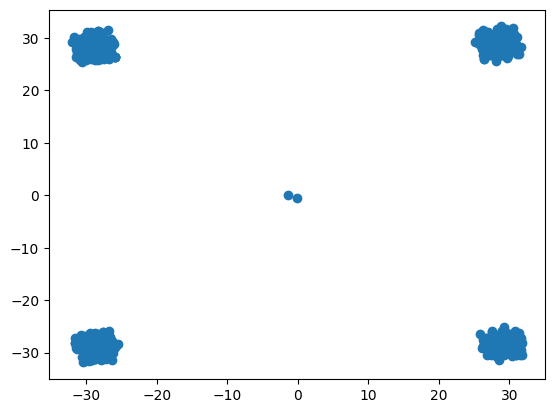

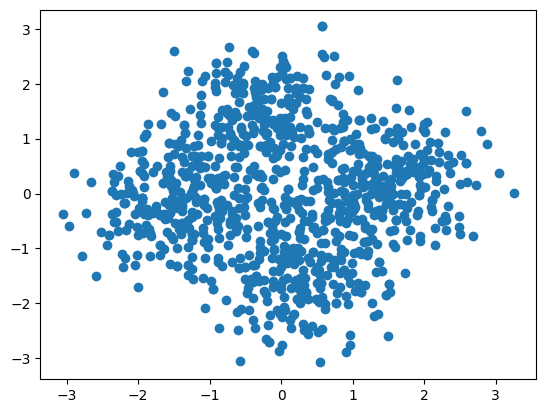

In [21]:
#Plotting Final from the filters
pxx,pxy,pyx,pyy=filters_state
pxx,pxy,pyx,pyy=taps['pxx'],taps['pxy'],taps['pyx'],taps['pyy']
x_test = E_in[:, 0] / np.sqrt(np.mean(np.abs(E_in[:, 0])**2))
y_test = E_in[:, 1] / np.sqrt(np.mean(np.abs(E_in[:, 1])**2))

x_out = np.convolve(x_test, pxx, mode='full') + np.convolve(y_test, pxy, mode='full')
y_out = np.convolve(x_test, pyx, mode='full') + np.convolve(y_test, pyy, mode='full')

plt.scatter(x_out.real, x_out.imag, label='Output X-pol')
plt.show()
plt.scatter(y_out.real, y_out.imag, label='Output Y-pol')
plt.show()